In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
from copy import copy
import subprocess
from funcs import *
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [118]:
from IPython.display import display, Javascript
import time
import hashlib
import shelve
import subprocess
import os

def save_and_commit(notebook_path, branch_name, nc_file, commit_message):
    
    current_branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode('ascii').strip()
    if current_branch != branch_name:
        raise ValueError('not on correct branch')
        
    if (os.path.exists(nc_file) or os.path.exists('./models/') or os.path.exists('./data/')) == False:
        raise ValueError('nc_file or target folder does not exist')
    
    start_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
        
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(notebook_path,'rb').read()).hexdigest()
                
    stage = ["git", "add", "{}".format(notebook_path)]
    commit = ["git", "commit", "-m", commit_message]
    try:
        proc = subprocess.check_output(stage, stderr=subprocess.STDOUT)
        proc = subprocess.check_output(commit, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError:
        raise ValueError('something went wrong')
        
    hashmark =  subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
    save_model = ["cp", "{}".format(nc_file), "./models/{}_{}.nc".format(branch_name, hashmark)]
    proc = subprocess.check_output(save_model, stderr=subprocess.STDOUT)

    bk = shelve.open('./data/{}_{}.pkl'.format(branch_name, hashmark),'n')
    exceptions = ['NPI_50m_DEM', 'NPI_DEM', 'NPI_DEM_o', 'R2_50m_Vel', 'R2_50m_Vx', 'R2_50m_Vy', 'R2_Vel', 'R2_Vx', 'R2_Vy', 'Z_09', 'Z_14', 'Z_50m_09', 'Z_50m_14', 'Z_50m_20', 'Z_50m_90', 'bed', 'bed_mask', 'bed_mask_meta', 'bed_o', 'dhdt_0914', 'dhdt_50m_0914', 'mat_DEM_Vel', 'mat_RADAR', 'ocean_50m_mask', 'retreat_50m_mask','smb_50m_fit', 'smb_fit', 'smb_net_0914', 'smb_net_df', 'smb_x', 'smb_y', 'smb_z', 'smb_xyz_df', 'surf', 'surf_mask','surf_mask_meta', 'surf_o', 'thk', 'thk_mask', 'thk_mask_meta', 'thk_o', 'vel_0914', 'vel_50m_0914', 'vel_df', 'vel_x', 'vel_y', 'vel_z', 'vel_xyz_df', 'x_50m', 'y_50m']
    for k in sorted(globals()):
        if k in exceptions:
            continue
        if k.split('_')[0]=='':
            continue
        try:
            bk[k] = globals()[k]
        except Exception:
            print('{} was not saved'.format(k))
            pass
    bk.close()

In [2]:
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "no",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": 1.0e-25,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [42]:
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 910.0             # [kg m-3]

Lx = 2 * 25e3  # in km
Ly = 2 * 25e3  # in km

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
topg = np.zeros((ny, nx))
tauc = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*268.15
precip = np.zeros((ny, nx))
land_ice_area_fraction_retreat = np.ones_like(topg)


for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        # add 10k to topography to prevent floating ice
        tauc[i, j] = 1e5*(1000 + np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0))
        topg[i,j ] = np.maximum(500 *(1-(dist*2/Lx)), 0)
        precip[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = topg[i,j]+1

thk = surf-topg

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 1.0,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 topg],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             268.0,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0.2 * ice_density,
                                  precip * ice_density],
        'land_ice_area_fraction_retreat' : ["1",
                                            "maximum ice extent mask",
                                            "",
                                            -1,
                                            land_ice_area_fraction_retreat],
        'tauc': ['Pa',
                 'yield stress for basal till (plastic or pseudo-plastic model)',
                 'yield stress',
                 0.0,
                 tauc],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



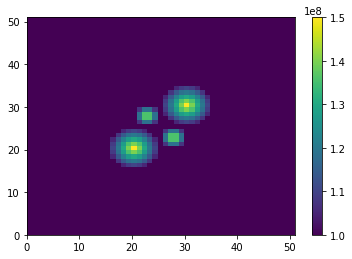

In [78]:
fig, axes = plt.subplots()
colors = plt.pcolor(tauc, axes=axes)
fig.colorbar(colors)

In [44]:
def create_script(forward_or_iteration):
    print("""#!/bin/bash
    ###### run script for experiment icecap ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx 51 -My 51 -Mz 30 -Mbz 1 -Lz 20000 -Lbz 1 -grid.recompute_longitude_and_latitude false"')
    print('PHYS="-stress_balance ssa+sia -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('CONF="-config_override icecap_conf.nc"')

    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 10e7"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# create icecap"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="diffusivity,temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag, uvel, vvel"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $SLIDING $THERMAL $CONF $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [45]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('icecap_build_script.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward')
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()

In [46]:
!chmod +x icecap_build_script.sh
!./icecap_build_script.sh 4 icecap_initialSetup.nc 15000 icecap_output.nc > icecap_output_log.txt

In [47]:
!tail icecap_output_log.txt

vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=1.07745)
S    14998.048:    0.00465    0.01040          0.01413      9.84353
  SSA:    10 outer iterations, ~16.0 KSP iterations each
vy$Eh  diffusivity (overrides reporting (-extra_times)) (dt=1.07745)
S    14999.126:    0.00465    0.01040          0.01413     10.64368
  SSA:     9 outer iterations, ~16.2 KSP iterations each
vy$Eh  reporting (-extra_times) (overrides end of the run) (dt=0.87441)
S    15000.000:    0.00465    0.01040          0.01413     10.29106
... done with run
Writing model state to file `icecap_output.nc'...


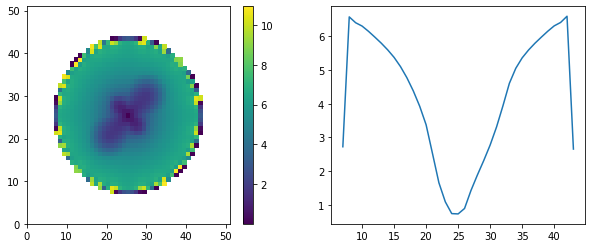

In [48]:
nc_data = get_nc_data('ex_icecap_output.nc', 'velbase_mag', -1)
nc_data2 = get_nc_data('ex_icecap_output.nc', 'thk', -2)
fig, axes = plt.subplots(1,2, figsize=(10,4))
colors = axes[0].pcolor(nc_data)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(nx), nc_data[26,:])

In [123]:
### bed recovery ###
S_ref = get_nc_data('icecap_output.nc', 'usurf', 0)
S_rec = copy.deepcopy(S_ref)

h_ref = get_nc_data('icecap_output.nc', 'thk', 0)
B_rec = np.zeros_like(topg)
dh_ref = np.zeros_like(topg)#nc_data - nc_data2
B_init = copy.deepcopy(B_rec)

tauc_rec = copy.deepcopy(tauc)
tauc_init = copy.deepcopy(tauc_rec)
vel_ref = get_nc_data('icecap_output.nc', 'velsurf_mag', 0)
vel_rec = copy.deepcopy(vel_ref)

mask = get_nc_data('icecap_output.nc', 'mask', 0)/2

B_rec_all = []
dh_all = []
B_misfit_vs_iter = []
dh_misfit_vs_iter = []
tauc_rec_all = []
vel_all = []
tauc_misfit_vs_iter=[]
vel_misfit_vs_iter=[]
misfit_thk_all = []
misfit_fr_all = []
S_rec_all = []

pmax = 100
dt = 0.1
beta = 1
bw = 4

!cp icecap_output.nc icecap_iteration_out.nc
    
original_stdout = sys.stdout
with open('icecap_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration')
    sys.stdout = original_stdout
    f.close()
!cp icecap_iteration_out.nc icecap_iteration_in.nc
!chmod +x icecap_iteration_script.sh

In [128]:
for p in tqdm.trange(0, pmax):
    
    
    h_old = S_ref - B_rec
    
    !cp icecap_iteration_out.nc icecap_iteration_in.nc
    #if p>0:
    #    mask = get_nc_data('icecap_iteration_in.nc', 'mask', 0)
    #    k = np.ones((bw+2, bw+2))
    #    buffer = ndimage.convolve(mask, k)/(bw+2)**2/2
    #    buffer[buffer>=.5] = 0
    #    buffer[buffer!=0] = (buffer[buffer!=0])*2
    #    B_rec -= (buffer) * np.mean(h_old) 
    #    h_old = S_ref - B_rec

    nc_updated = NC('icecap_iteration_in.nc', 'r+')
    nc_updated['tauc'][0,:,:]=tauc_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['topg'][0,:,:]=B_rec
    #nc_updated['climatic_mass_balance'][0,:,:]=np.maximum(nc_updated['climatic_mass_balance'][0:,:],0)
    nc_updated.close()
        
    cmd = ["./icecap_iteration_script.sh", '4', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
    
    vel_rec = get_nc_data('icecap_iteration_out.nc', 'velsurf_mag', 0)
    h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0)
    u[criterion] = 0
    v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0)
    v[criterion] = 0
    
    misfit_fr = shift((vel_ref-vel_rec), u, v, .3)
    misfit_thk = shift((dh_rec-dh_ref), u, v, .3)
    #misfit = dh_rec - dh_ref
    
    #misfit_lowpass = ndimage.gaussian_filter(misfit, 1)
    #misfit_highpass = misfit - misfit_lowpass
    
    tauc_rec = tauc_rec - beta * (misfit_fr)*1e6
    B_rec = B_rec - beta * (misfit_thk)
    #S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*.05) * misfit_highpass[np.logical_and(mask==1, h_rec>20)] 
    #S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*0.02) * misfit[np.logical_and(mask==1, h_rec>20)] 

    '''

    H_rec = S_ref - B_rec
    B_rec = ndimage.gaussian_filter(H_rec, 1, truncate=1)
    B_rec = S_ref - H_rec
    '''
    ### buffer ###
    B_rec[criterion]=0
    #h_inpaint = S_rec - B_rec
    #h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    #h_inpaint = inpaint_nans(h_inpaint)
    #B_rec = S_rec - h_inpaint
    tauc_rec[criterion]=1e8
    ### buffer end ###

    B_rec[mask==0] = S_ref[mask==0]
    B_rec[B_rec>S_ref] = S_ref[B_rec>S_ref]
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    tauc_rec[mask==0] = tauc[mask==0]
    tauc_rec_all.append(tauc_rec)
    vel_all.append(vel_rec)
    #S_rec_all.append(S_rec)
    
    tauc_misfit_vs_iter.append(np.mean(abs(tauc_rec[mask==1]-tauc[mask==1])))
    vel_misfit_vs_iter.append(np.mean(abs(vel_rec[mask==1]-vel_ref[mask==1])))
    B_misfit_vs_iter.append(np.mean(abs(B_rec[mask==1]-topg[mask==1])))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))
    misfit[mask==0] = np.nan
    misfit_fr_all.append(misfit_fr)
    misfit_thk_all.append(misfit_thk)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


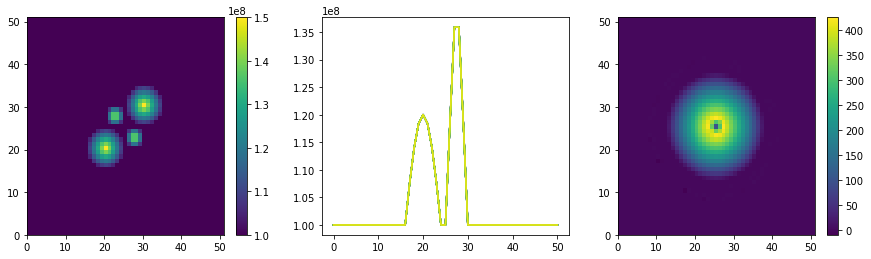

In [129]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(tauc_rec_all))]
fig, axes = plt.subplots(1,3, figsize=(15,4))
field = axes[0].pcolor(tauc_rec, vmin = 10e7, vmax = 1.5e8)
fig.colorbar(field, ax=axes[0])
for i in range(0,len(tauc_rec_all),10):
    lines = axes[1].plot(range(nx), tauc_rec_all[i][:,23], color=colors[i])
    
field2 = axes[2].pcolor(B_rec)
fig.colorbar(field2, ax = axes[2])
#lines1 = axes[1].plot(range(nx), topg[:,23])
#lines2 = axes[1].plot(range(nx), S_ref[:,23])
#lines3 = axes[1].plot(range(nx), S_rec[:,23], 'r')
#lines4 = axes[2].pcolor(S_ref - S_rec, cmap='RdBu', vmin=-20, vmax=20)
#fig.colorbar(lines4, ax = axes[2])

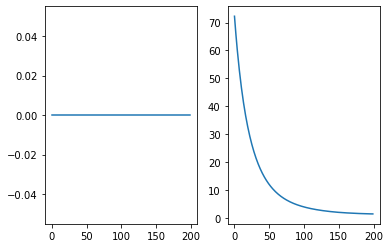

In [130]:
fig, ax = plt.subplots(1,2)
ax[0].plot(tauc_misfit_vs_iter)
ax[1].plot(B_misfit_vs_iter)

Text(0, 0.5, 'elevation (m)')

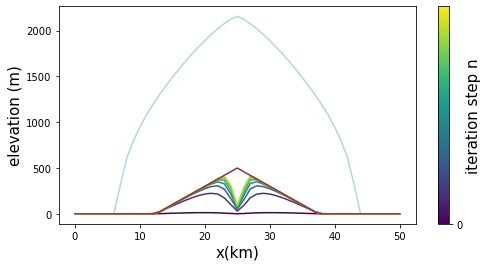

In [134]:
from matplotlib import colors as plt_colors

colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
bounds=np.linspace(0,len(B_rec_all), 1000)
norm = plt_colors.BoundaryNorm(bounds, colormap.N)

fig, axes = plt.subplots(figsize=(8,4))
for i in range(0,len(B_rec_all),30):
    lines = axes.plot(range(nx), B_rec_all[i][:,25], color=colors[i])
lines2 = axes.plot(range(nx), S_ref[:,25], color = 'lightblue')
lines1 = axes.plot(range(nx), topg[:,25], color='brown')
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax = axes, ticks=[0,500, 1000, 1500, 2000, 2500, 3000])
cbar.set_label('iteration step n', fontsize= 15)
axes.set_xlabel('x(km)', fontsize= 15)
axes.set_ylabel('elevation (m)', fontsize= 15)
#plt.savefig('./figures/icecap_crosssection.png', dpi = 400)

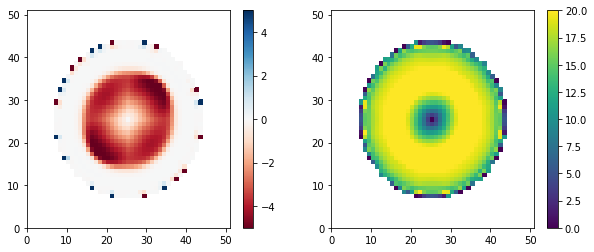

In [108]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
field = ax[0].pcolor(vel_ref-vel_rec, vmin = -5, vmax = 5, cmap='RdBu')
field1 = ax[1].pcolor(vel_rec, vmin = 0, vmax = 20)
fig.colorbar(field, ax = ax[0])
fig.colorbar(field1, ax = ax[1])

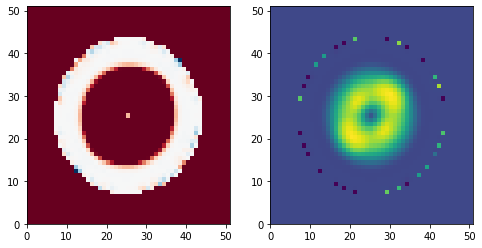

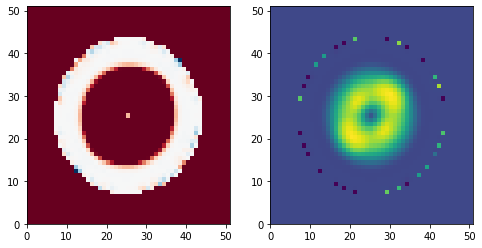

In [67]:
from IPython.display import display, clear_output
fig, axes = plt.subplots(1,2,figsize=(8,4))
for i in range(0,len(tauc_rec_all),10):
    field = axes[0].pcolor(misfit_fr_all[i], cmap='RdBu', vmin=-1, vmax=1)
    field = axes[1].pcolor(tauc_rec_all[i])
    #fig.colorbar(field, ax=axes[0])
    clear_output(wait=True)
    display(fig)

In [ ]:
save_and_commit('./icecap.ipynb', 'icecap', 'icecap_iteration_out.nc', 'recover basal friction and thickness with both velocities and dh; both outputs can be recovered with any of inputs, but not at the same time it seem')